# Inference and Prediction with Machine Learning

## Financial Dataset

In [1]:
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt

def load_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print("Successful search. Data found at position")
    except FileNotFoundError:
        print("No data found at position. Downloading the data from external source... \n Download complete!")
        df = data.DataReader("AAPL", "yahoo", start_date, end_date)
        df.to_pickle(output_file)
    return df

apple_data = load_data(start_date = "2001-1-1", 
                       end_date = "2020-1-1", 
                      output_file = "apple_data_large.pkl")

/Users/mariohernandeztinoco/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Successful search. Data found at position


## Creating objectives/trading conditions that we want to predict

We need to operate on our data to extract our target for the predictive models, also known as a response or dependent variable; effectively, what we are trying to predict.

For algorithmic investment trading strategiesw, the common target is to be able to predict what the future price will be so that we can take positions in the market right now that will yield a profit in the future. If we model the response variableas future price-current price, then we are trying to predict the direction of the future price with regard to the current price (does it go up, does it go down, or does it remain the same), as well as the magnitude of the price change. Another variant of the response variable would be to simply predict the direction but ignore the magnitude, in other words, +1 to signify the future price moving up, -1 to signifiy the future price moving down, and 0 to signify that the future price remains the same as the current price. Let's implement the following code to generate the response variables:

In [2]:
def create_classification_trading_condition(df):
    df["Open-Close"] = df["Open"] - df["Close"]
    df["High-Low"] = df["High"] - df["Low"]
    df = df.dropna()
    
    X = df[["Open-Close", "High-Low"]]
    Y = np.where(df["Close"].shift(-1) > df["Close"], 1, -1)
    
    return (X, Y)

- The classification response variable is +1 if the close price tomorrow is higher than the close price today, and -1 if the close price tomorrow is lower than the close price today.


The regression response variable is Close price tomorrow - Close price today for each day. Let's have a look at the code:

In [3]:
def create_regression_trading_condition(df):
    df["Open-Close"] = df["Open"] - df["Close"]
    df["High-Low"] = df["High"] - df["Low"]
    df = df.dropna()
    X = df[["Open-Close", "High-Low"]]
    Y = df["Close"].shift(-1) - df["Close"]
    
    return(X, Y)

In this code, the following applies:

- It is a positive value if the price goes up tomorrow, a negative value if the price goes down tomorrow, and zero if the price does not change.

- The sign of the value indicates the direction, and the magnitude of the response variable captures the magnitude of the price move.

## Partitioning Datasets into Training and testing Datasets

One of the key questions regarding a trading investment strategy is how it will perform on market conditions or datasets that the trading strategy has not seen. Trading performance on datasets that have not been used in training the predictive model is often referred to as out-of-sample performance for that trading strategy. These results are considered representative of what to expect when the trading strategy is run in live markets. Generally, we divide all of our available datasets into multiple partitions, and then we evaluate models trained on one dataset over a dataset that wasn't used in training it (and optionally validated on yet another dataset after that). For the purpose of our models, we will be partitioning our dataset into two datasets: training and testing. Let's have a look at the code:

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
def create_train_split_group(X, Y, split_ratio = 0.8):
    return train_test_split(X, Y, shuffle = False, train_size = split_ratio)

## Ordinary Least Squares

1.- Let's start by loading up Apple data in the code, using the same method that we introduced in the previous section:

In [6]:
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt

def load_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print("Successful search. Data found at position")
    except FileNotFoundError:
        print("No data found at position. Downloading the data from external source... \n Download complete!")
        df = data.DataReader("AAPL", "yahoo", start_date, end_date)
        df.to_pickle(output_file)
    return df

apple_data = load_data(start_date = "2001-1-1", 
                       end_date = "2020-1-1", 
                      output_file = "apple_data_large.pkl")

Successful search. Data found at position


2.- Now, we create and populate the target variable vector, Y, for regression in the following code. Remember that what we are trying to predict in regression is magnitude and the direction of the price change from one day to the next:

In [7]:
def create_regression_trading_condition(df):
    df["Open-Close"] = df["Open"] - df["Close"]
    df["High-Low"] = df["High"] - df["Low"]
    df["Target"] = df["Close"].shift(-1) - df["Close"]
    df = df.dropna()
    X = df[["Open-Close", "High-Low"]]
    Y = df[["Target"]]
    return (df, X, Y)

In [8]:
apple_data, X, Y = create_regression_trading_condition(apple_data)

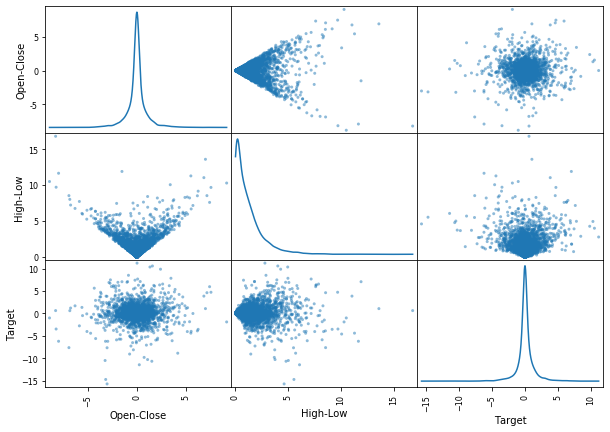

In [9]:
pd.plotting.scatter_matrix(apple_data[["Open-Close", "High-Low", "Target"]], 
                           grid = True, diagonal = "kde", alpha = 0.5, figsize = (10, 7))
plt.show()

Let's split 80% of the available data into the training feature value and the target variable set (X_train, Y_train), and the remaining 20% of thedataset into the out-of-sample testing feature value and target variable set (X_test, Y_test):

In [10]:
from sklearn.model_selection import train_test_split

def create_train_split_group(X, Y, split_ratio = 0.8):
    return train_test_split(X, Y, shuffle = False, train_size = split_ratio)

In [11]:
X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y)                                                  

The following code fits the OLS model as shown below and observe the model we obtain:

In [12]:
from sklearn import linear_model

ols = linear_model.LinearRegression()
ols.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The coefficients are the optimal weights assigned to the two features by the fit method.

In [13]:
print("Coefficients: \n", ols.coef_)

Coefficients: 
 [[0.05481136 0.01047411]]


In [14]:
from sklearn.metrics import mean_squared_error, r2_score

# The mean squared error
print("Mean squared error Train: %.3f" % mean_squared_error(Y_train, 
                                                      ols.predict(X_train)))

# Explained variance score: 1 is perfect prediction      
print("Variance score Train: %.3f" % r2_score(Y_train,
                                     ols.predict(X_train)))

# The mean squared error
print("Mean squared error Test: %.3f" %mean_squared_error(Y_test,
                                                    ols.predict(X_test)))

# Explained Variance score: 1 is perfect prediction
print("Variance score Test: %.3f" % r2_score(Y_test,
                                       ols.predict(X_test)))


Mean squared error Train: 0.790
Variance score Train: 0.002
Mean squared error Test: 6.902
Variance score Test: -0.003


Let's use it to predict prices and calculate strategy returns:

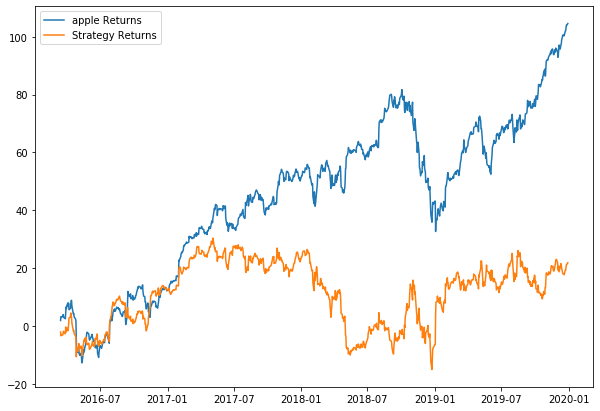

In [15]:
import numpy as np

apple_data["Predicted_Signal"] = ols.predict(X)
apple_data["Predicted_Signal"] = np.where(apple_data["Predicted_Signal"] > 0, 1, -1)
apple_data["apple_Returns"] = np.log(apple_data["Close"] / apple_data["Close"].shift(1))

def calculate_return(df, split_value, symbol):
    cum_apple_return = df[split_value: ]["%s_Returns" % symbol].cumsum() * 100
    df["Strategy_Returns"] = df["%s_Returns" % symbol] * df["Predicted_Signal"].shift(1)
    return cum_apple_return

def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return = df[split_value:]["Strategy_Returns"].cumsum() * 100
    return cum_strategy_return

cum_apple_return = calculate_return(apple_data, split_value = len(X_train), symbol = "apple")


cum_strategy_return = calculate_strategy_return(apple_data, split_value = len(X_train), symbol = "apple")


def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize = (10, 7))
    plt.plot(cum_symbol_return, label = "%s Returns" % symbol)
    plt.plot(cum_strategy_return, label = "Strategy Returns")
    plt.legend()

plot_chart(cum_apple_return, cum_strategy_return, symbol = "apple")


# Regularization and Shrinkage - LASSO and Ridge Regression

Let's apply LASSO regression to our dataset and inspect the coefficients in the following code. With a regularization parameter of 0.1, we see that the first predictor gets assigned a coeficient that is considerably smaller than what was assigned by OLS:

In [16]:
from sklearn import linear_model

# Fit the model
lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(X_train, Y_train)

# The coefficients
print("Coefficients: \n", lasso.coef_)

Coefficients: 
 [0. 0.]


Now, let's apply Ridge regression to our dataset and observe the coefficients:

In [17]:
# from sklearn import linear_model

# Fit the model
ridge = linear_model.Ridge(alpha = 0.1)
ridge.fit(X_train, Y_train)

# The coefficients
print("Coefficients: \n", ridge.coef_)

Coefficients: 
 [[0.05480875 0.01047392]]


Lasso is quite similar conceptually to ridge regression. It also adds a penalty for non-zero coefficients, but unlike ridge regression which penalizes sum of squared coefficients (L2 penalty), lasso penalizes the sum of their absolute values (L1 penalty). As a result, for high values of λ, many coefficients are exactly zeroed under lasso, which is never the case in ridge regression.

In the first part of this class, we reviewed trading strategies based on regression machine learning algorithms. In this second part, we will focus on the classification of machine learning  method utilizing known datasets to make predictions. Instead of the output variable of the regression being a numerical (or continuous) value, the classification output is a categorical (or discrete) value. We will use the same method as the regression analysis by finding the mapping function (f) such that whenever there is new input data (x), the output variable (y) for the dataset can be predicted.

### K-nearest Neighbors

K- nearest neighbors (or KNN) is a supervised method. The goal is to find a function predicting an output, y, from an unseen observation, x. Unlike a lot of other methods (such as linear regression), this method doesn't use any specific assumption about the distribution of the data (it is referred to as a non-parametric classifier). 

In [18]:
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt

def load_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print("Successful search. Data found at position")
    except FileNotFoundError:
        print("No data found at position. Downloading the data from external source... \n Download complete!")
        df = data.DataReader("AAPL", "yahoo", start_date, end_date)
        df.to_pickle(output_file)
    return df

In [19]:
apple_data = load_data(start_date = "2001-1-1", 
                       end_date = "2020-1-1", 
                      output_file = "apple_data_large.pkl")

Successful search. Data found at position


Rule when the strategy will take a long position (+1) and a short position (-1):

In [20]:
def create_classification_trading_condition(df):
    df["Open-Close"] = df["Open"] - df["Close"]
    df["High-Low"] = df["High"] - df["Low"]
    df = df.dropna()
    
    X = df[["Open-Close", "High-Low"]]
    Y = np.where(df["Close"].shift(-1) > df["Close"], 1, -1)
    
    return (X, Y)

X, Y = create_classification_trading_condition(apple_data)

Prepares the training and testing dataset:

In [21]:
from sklearn.model_selection import train_test_split

def create_train_split_group(X, Y, split_ratio = 0.8):
    return train_test_split(X, Y, shuffle = False, train_size = split_ratio)

X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y)

Choose a KNN with K = 15. We will train this model using the training dataset:

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

Once the model is created, we are going to predict whether the price goes up or down and store the values in the original data frame:

In [23]:
apple_data["Predicted_Signal"] = knn.predict(X)

6.- In order to compare the strategy using the KNN algorithm, we will use the return of Apple (benchamrk):

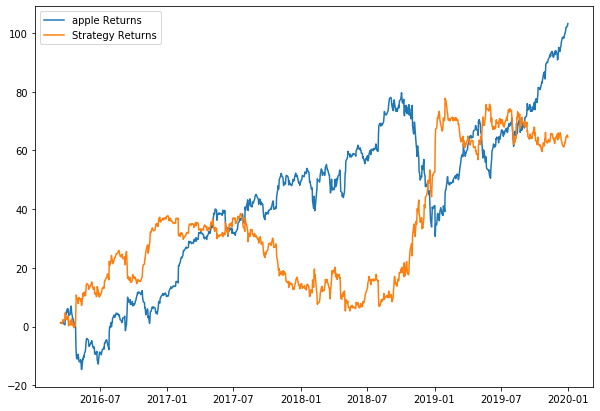

In [24]:
apple_data["apple_Returns"] = np.log(apple_data["Close"] / apple_data["Close"].shift(1))

def calculate_return(df, split_value, symbol):
    cum_apple_return = df[split_value: ]["%s_Returns" % symbol].cumsum() * 100
    df["Strategy_Returns"] = df["%s_Returns" % symbol] * df["Predicted_Signal"].shift(1)
    return cum_apple_return

def calculate_strategy_return(df, split_value):
    cum_strategy_return = df[split_value: ]["Strategy_Returns"].cumsum() * 100
    return cum_strategy_return

cum_apple_return = calculate_return(apple_data, split_value = len(X_train), symbol = "apple")
cum_strategy_return = calculate_strategy_return(apple_data, split_value = len(X_train))

def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize = (10, 7))
    plt.plot(cum_symbol_return, label = "%s Returns" % symbol)
    plt.plot(cum_strategy_return, label = "Strategy Returns")
    plt.legend()
    plt.show()
    
plot_chart(cum_apple_return, cum_strategy_return, symbol = "apple")
    

In [25]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()

sharpe_ratio(cum_strategy_return, cum_apple_return)

0.33560531853844766

## Support Vector Machines

Support Vector Machine (SVM) is a supervised machine learning method. As previously seen, we can use this method for regression, but also for classification. The principle of this algorithmis to find a hyper plan that separates the data into two classes.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from pandas_datareader import data

In [27]:
def load_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print("Successful search. Data found at position")
    except FileNotFoundError:
        print("No data found at position. Downloading the data from external source... \n Download complete!")
        df = data.DataReader("AAPL", "yahoo", start_date, end_date)
        df.to_pickle(output_file)
    return df

apple_data = load_data(start_date = "2001-1-1", 
                       end_date = "2020-1-1", 
                      output_file = "apple_data_large.pkl")

Successful search. Data found at position


In [28]:
def create_trading_condition(df):
    df["Open-Close"] = df["Open"] - df["Close"]
    df["High-Low"] = df["High"] - df["Low"]
    df = df.dropna()
    X = df[["Open-Close", "High-Low"]]
    Y = np.where(df["Close"].shift(-1) > df["Close"], 1, -1)
    return(X, Y)

def create_train_split_group(X, Y, split_ratio = 0.8):
    return train_test_split(X, Y, shuffle = False, train_size = split_ratio)

X, Y = create_trading_condition(apple_data) 

X_train, X_test, Y_train, Y_test = create_train_split_group(X, Y)


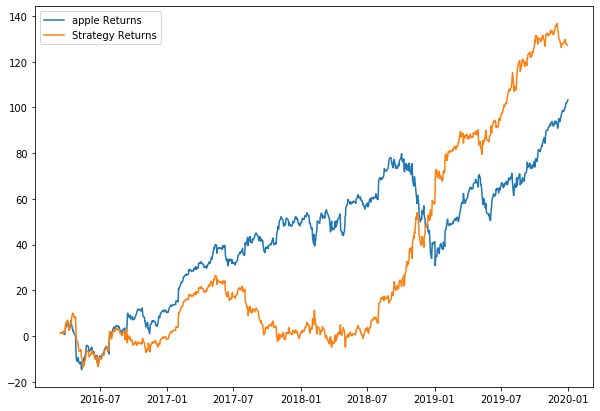

In [29]:
# Fit the model 
svc = SVC()
svc.fit(X_train, Y_train)

# Forecast Value
apple_data["Predicted_Signal"] = svc.predict(X)
apple_data["apple_Returns"] = np.log(apple_data["Close"] / apple_data["Close"].shift(1))

def calculate_return(df, split_value, symbol):
    cum_apple_return = df[split_value: ]["%s_Returns" % symbol].cumsum() * 100
    df["Strategy_Returns"] = df["%s_Returns" % symbol] * df["Predicted_Signal"].shift(-1)
    return cum_apple_return

def calculate_strategy_return(df, split_value):
    cum_strategy_return = df[split_value: ]["Strategy_Returns"].cumsum() * 100
    return cum_strategy_return

cum_apple_return = calculate_return(apple_data, split_value = len(X_train), symbol = "apple")
cum_strategy_return = calculate_strategy_return(apple_data, split_value = len(X_train))

def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize = (10, 7))
    plt.plot(cum_symbol_return, label = "%s Returns" % symbol)
    plt.plot(cum_strategy_return, label = "Strategy Returns")
    plt.legend()
    plt.show()
    
plot_chart(cum_apple_return, cum_strategy_return, symbol = "apple")


In [30]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()

In [31]:
accuracy_train = accuracy_score(Y_train, svc.predict(X_train))
accuracy_test = accuracy_score(Y_test, svc.predict(X_test))
print(accuracy_train, accuracy_test)
print(sharpe_ratio(cum_strategy_return, cum_apple_return))

0.5289040020925975 0.5135983263598326
0.34333995244978927


## Logistic regression

Logistic regression is a supervised method that works for classification. Based on linear regression, logistic regression transforms its output using the logistic sigmoid, returning a probability value that maps different classes.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from pandas_datareader import data

In [33]:
def load_data(start_date, end_date, output_file):
    try:
        df = pd.read_pickle(output_file)
        print("Successful search. Data found at position")
    except FileNotFoundError:
        print("No data found at position. Downloading the data from external source... \n Download complete!")
        df = data.DataReader("AAPL", "yahoo", start_date, end_date)
        df.to_pickle(output_file)
    return df

apple_data = load_data(start_date = "2001-1-1", 
                       end_date = "2020-1-1", 
                      output_file = "apple_data_large.pkl")

Successful search. Data found at position


In [34]:
apple_data["Open-Close"] = apple_data["Open"] - apple_data["Close"]
apple_data["High-Low"] = apple_data["High"] - apple_data["Low"]
apple_data = apple_data.dropna()
X = apple_data[["Open-Close", "High-Low"]]
Y = np.where(apple_data["Close"].shift(-1) > apple_data["Close"], 1, -1)

split_ratio = 0.8
split_value = int(split_ratio * len(apple_data)) # split value = 2692
X_train = X[ :split_value]
Y_train = Y[ :split_value]
X_test = X[split_value: ]
Y_test = Y[split_value: ]

In [35]:
logistic = LogisticRegression()
logistic.fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, logistic.predict(X_train))
accuracy_test = accuracy_score(Y_test, logistic.predict(X_test))
print(accuracy_train, accuracy_test)

0.5192257389484698 0.5156903765690377


In [36]:
apple_data["Predicted_Signal"] = logistic.predict(X)
apple_data["apple_Returns"] = np.log(apple_data["Close"] / apple_data["Close"].shift(1))


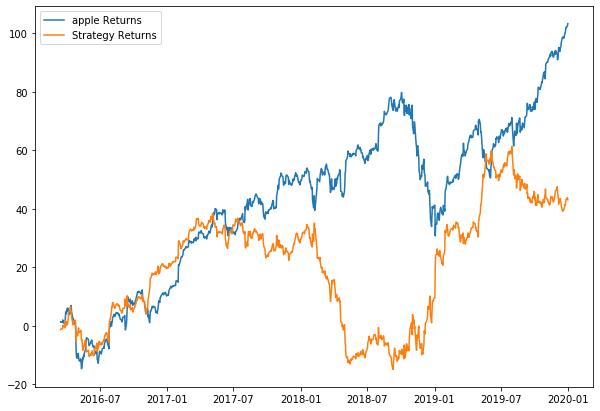

In [37]:
def calculate_return(df, split_value, symbol):
    cum_apple_return = df[split_value: ]["%s_Returns" % symbol].cumsum() * 100
    df["Strategy_Returns"] = df["%s_Returns" % symbol] * df["Predicted_Signal"].shift(1)
    return cum_apple_return

def calculate_strategy_return(df, split_value):
    cum_strategy_return = df[split_value: ]["Strategy_Returns"].cumsum() * 100
    return cum_strategy_return

cum_apple_return = calculate_return(apple_data, split_value = len(X_train), symbol = "apple")
cum_strategy_return = calculate_strategy_return(apple_data, split_value = len(X_train))    


def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    plt.figure(figsize = (10, 7))
    plt.plot(cum_symbol_return, label = "%s Returns" % symbol)
    plt.plot(cum_strategy_return, label = "Strategy Returns")
    plt.legend()
    plt.show()
    
plot_chart(cum_apple_return, cum_strategy_return, symbol = "apple")


In [38]:
def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()

accuracy_train = accuracy_score(Y_train, logistic.predict(X_train))
accuracy_test = accuracy_score(Y_test, logistic.predict(X_test))
print(accuracy_train, accuracy_test)
print(sharpe_ratio(cum_strategy_return, cum_apple_return))

0.5192257389484698 0.5156903765690377
0.8257819476214351


In this section, we got a basic understanding of how to use machine learning in trading. We started with going through the essential terminology and notation. We learned to create predicitve models that predict price movements using linear regression methods. We built several codes using Python's scikit-learn library. We saw how to create predictive models that predict buy and sell signals using linear classification methods. We also demonstrated how to apply these machine learning methods to a simple trading strategy. We also went through the tools that we can use to create a trading strategy.

`End of File`